# Rotating Half-Moons Classification

# 0. Imports and Data Load

In [17]:
from functools import partial
from typing import Sequence

import numpy as np
import matplotlib.pyplot as plt
from flax import linen as nn
import jax
import jax.random as jr
import jax.numpy as jnp
from jax import jit, vmap
import optax
from bayes_opt import BayesianOptimization

from rebayes.utils import moons_data
from rebayes.utils import utils
from rebayes.base import RebayesParams
from rebayes.low_rank_filter.lofi import LoFiParams, RebayesLoFi, LoFiBel
from rebayes.extended_kalman_filter.ekf import RebayesEKF

In [2]:
%config InlineBackend.figure_format = "retina"
%load_ext autoreload
%autoreload 2

In [69]:
n_train, n_test = 200, 200
n_rotations = 4
noise = 0.3

In [70]:
train, test = moons_data.make_rotating_moons(n_train, n_test, n_rotations, max_angle=180, noise=0.2)
X_train, y_train, rotations_train = train
X_test, y_test, rotations_test = test

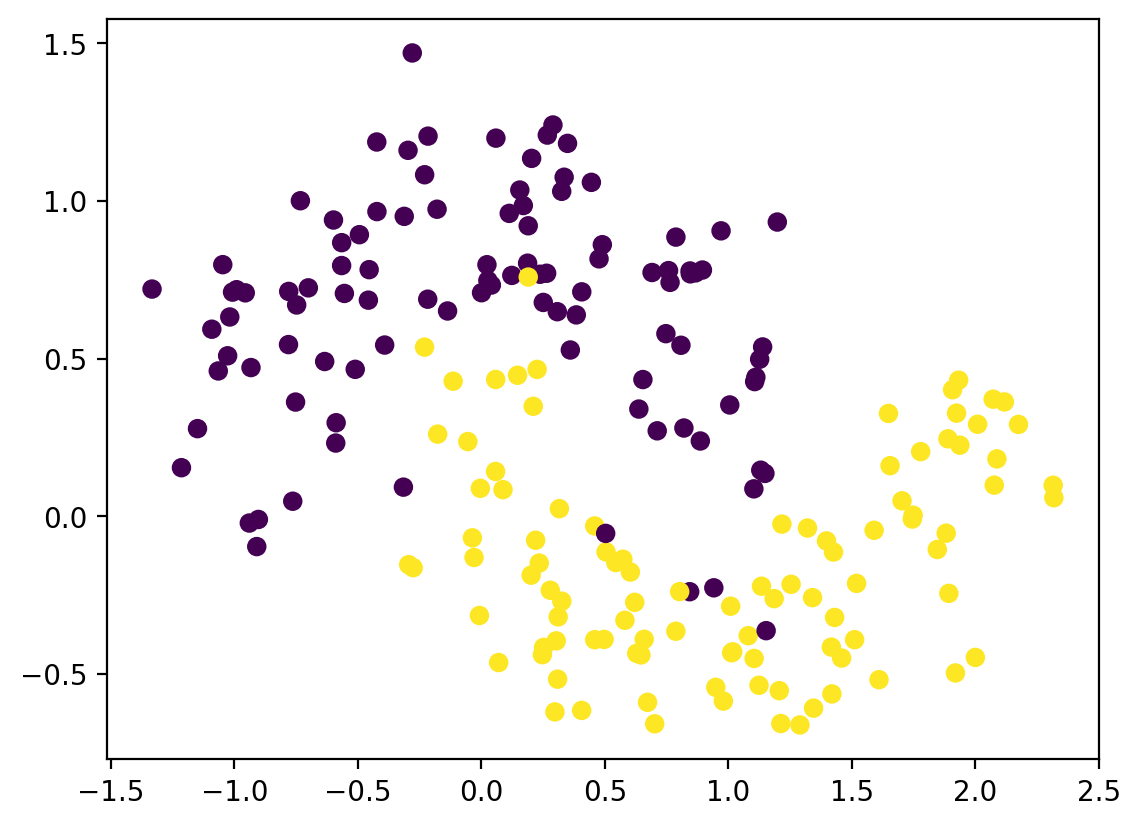

In [71]:
fig, ax = plt.subplots()
ax.scatter(*X_train[:n_train].T, c=y_train[:n_train]);

In [72]:
# Define the MLP model
input_dim, hidden_dims, output_dim = 2, [25, 25,], 1
model_dims = [input_dim, *hidden_dims, output_dim]
_, flat_params, _, apply_fn = utils.get_mlp_flattened_params(model_dims)
print(flat_params.shape)

(751,)


In [73]:
eps = 1e-4
sigmoid_fn = lambda w, x: jnp.clip(jax.nn.sigmoid(apply_fn(w, x)), eps, 1-eps) # Clip to prevent divergence
emission_mean_function = lambda w, x: sigmoid_fn(w, x)
emission_cov_function = lambda w, x: sigmoid_fn(w, x) * (1 - sigmoid_fn(w, x))

In [133]:
def callback_fn(bel, pred, t, X, y, bel_pred, **kwargs):
    X_test, y_test = kwargs["X_test"], kwargs["y_test"]
    apply_fn = kwargs["apply_fn"]
    
    logits = vmap(jit(apply_fn), (None, 0))(bel.mean, X_test).squeeze()
    test_nll = jnp.mean(jit(optax.sigmoid_binary_cross_entropy)(logits, y_test))
    test_miscl = jnp.mean(jnp.round(jax.nn.sigmoid(logits)) != y_test)
    osa_nll = -(y * jnp.log(pred) + (1 - y) * jnp.log(1 - pred)).mean()
    
    result = {
        'test_nll': test_nll,
        'test_miscl': test_miscl,
        'osa_nll': osa_nll,
    }
    
    return result 

# 1. FCEKF

## 1.1 Hyperparam Tuning

In [114]:
def opt_fn(X, y, log_init_cov, log_dynamics_weights, log_dynamics_cov, log_alpha, method='fcekf'):
    model_params = RebayesParams(
        initial_mean=flat_params,
        initial_covariance=jnp.power(10, log_init_cov),
        dynamics_weights=1.0-jnp.power(10, log_dynamics_weights),
        dynamics_covariance=jnp.power(10, log_dynamics_cov),
        emission_mean_function=emission_mean_function,
        emission_cov_function=emission_cov_function,
        dynamics_covariance_inflation_factor=jnp.power(10, log_alpha)
    )
    if method[-3:] == 'ekf':
        estimator = RebayesEKF(model_params, method=method)
    elif method[-4:] == 'lofi':
        lofi_params = LoFiParams(
            memory_size=20,
        )
        estimator = RebayesLoFi(model_params, lofi_params, method=method)

    test_kwargs = {'X_test': X, 'y_test': y, 'apply_fn': apply_fn}
    bel, output = estimator.scan(X, y, callback=callback_fn, progress_bar=False, **test_kwargs)
    
    osa_nll = output['osa_nll']
    
    result = -osa_nll.mean()
    if jnp.isnan(result):
        result = -1e6
    return result


In [85]:
fcekf_opt_fn = partial(opt_fn, X=X_train, y=y_train, method='fcekf')
fcekf_optimizer = BayesianOptimization(
    f=fcekf_opt_fn,
    pbounds={
        'log_init_cov': (-8, -0.1),
        'log_dynamics_weights': (-8, -0.1),
        'log_dynamics_cov': (-8, -0.1),
        'log_alpha': (-8, -0.1),
    }
)


In [77]:
fcekf_optimizer.maximize(
    init_points=50,
    n_iter=50,
)

|   iter    |  target   | log_alpha | log_dy... | log_dy... | log_in... |
-------------------------------------------------------------------------
| 1         | -0.6932   | -4.484    | -2.624    | -0.4402   | -5.629    |
| 2         | -0.6297   | -5.88     | -4.847    | -7.81     | -6.5      |
| 3         | -1e+06    | -0.9042   | -1.903    | -4.436    | -4.236    |
| 4         | -0.6996   | -2.773    | -0.5704   | -0.2222   | -1.39     |
| 5         | -0.6932   | -6.133    | -4.426    | -0.5609   | -0.44     |
| 6         | -0.4332   | -3.676    | -1.614    | -2.5      | -7.919    |
| 7         | -0.6421   | -5.906    | -4.964    | -5.968    | -6.822    |
| 8         | -0.7043   | -4.374    | -6.212    | -4.345    | -7.849    |
| 9         | -0.6937   | -1.855    | -3.909    | -1.401    | -1.204    |
| 10        | -0.6961   | -4.731    | -1.446    | -0.7675   | -0.9793   |
| 11        | -0.3552   | -2.401    | -2.958    | -7.775    | -2.516    |
| 12        | -0.3517   | -6.137    | 

In [83]:
# 'log_alpha': -4.6425647103370675, 'log_dynamics_cov': -7.92291423125116, 'log_dynamics_weights': -6.178496045258433, 'log_init_cov': -0.42096786472423897
print(fcekf_optimizer.max)

{'target': -0.28712448477745056, 'params': {'log_alpha': -4.6425647103370675, 'log_dynamics_cov': -7.92291423125116, 'log_dynamics_weights': -6.178496045258433, 'log_init_cov': -0.42096786472423897}}


##  1.2 Test-Set OSA Eval

In [134]:

def apply_model(X, y, log_init_cov, log_dynamics_weights, log_dynamics_cov, log_alpha, method='fcekf', bel=None):
    model_params = RebayesParams(
        initial_mean=flat_params,
        initial_covariance=jnp.power(10, log_init_cov),
        dynamics_weights=1.0-jnp.power(10, log_dynamics_weights),
        dynamics_covariance=jnp.power(10, log_dynamics_cov),
        emission_mean_function=emission_mean_function,
        emission_cov_function=emission_cov_function,
        dynamics_covariance_inflation_factor=jnp.power(10, log_alpha)
    )
    if method[-3:] == 'ekf':
        estimator = RebayesEKF(model_params, method=method)
    elif method[-4:] == 'lofi':
        lofi_params = LoFiParams(
            memory_size=20,
        )
        estimator = RebayesLoFi(model_params, lofi_params, method=method)

    test_kwargs = {'X_test': X, 'y_test': y, 'apply_fn': apply_fn}
    bel, output = estimator.scan(X, y, callback=callback_fn, progress_bar=False, **test_kwargs, bel=bel)
    
    return bel, output

In [99]:
# Tuned hyperparams
log_alpha=-4.6425647103370675
log_dynamics_cov=-7.92291423125116
log_dynamics_weights=-6.178496045258433
log_init_cov=-0.42096786472423897

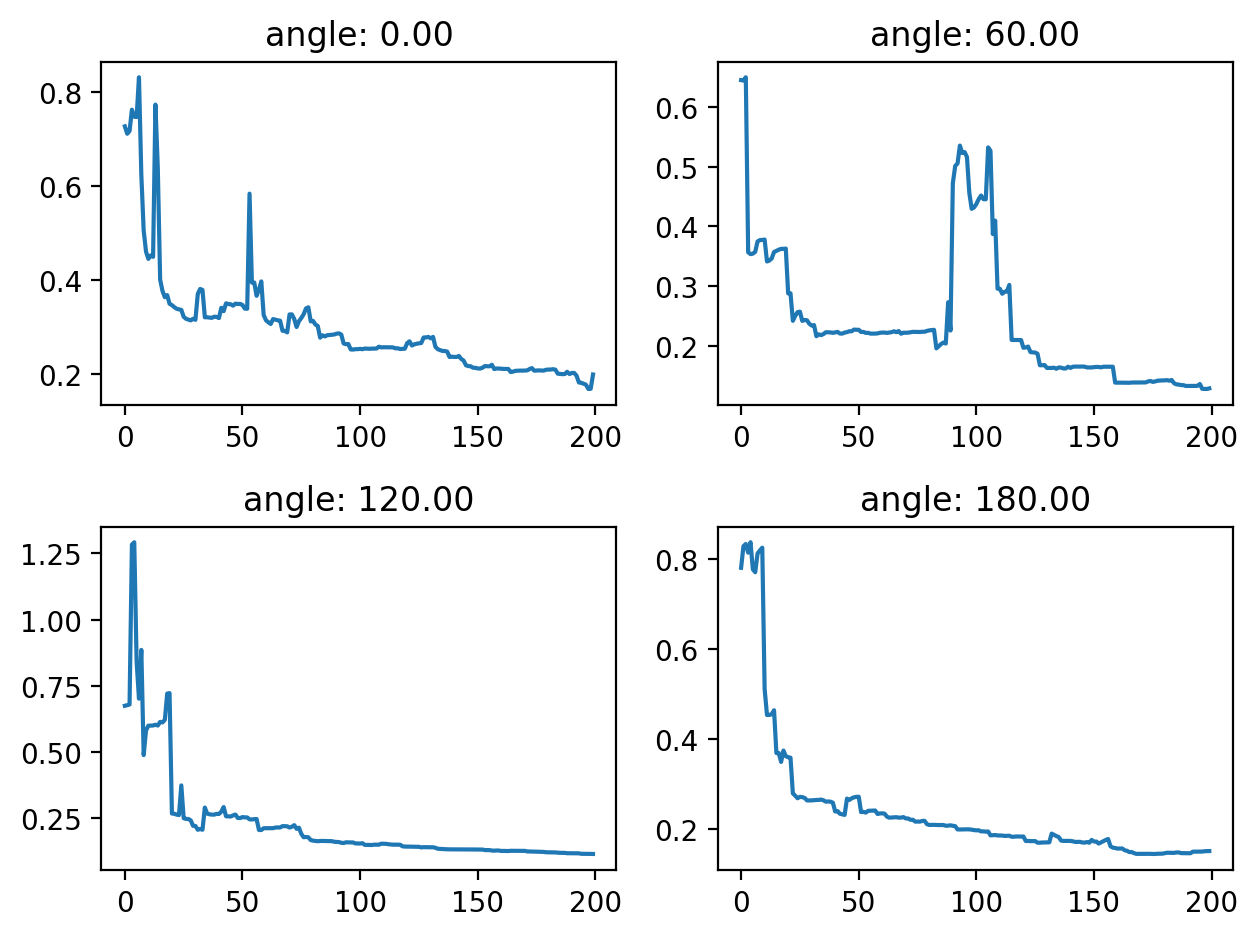

In [136]:
fcekf_outputs, bel = [], None

fig, axs = plt.subplots(2, 2)
axs = axs.ravel()

for i, ax in enumerate(axs):
    slice_ix = slice(i * n_train, n_train * (i + 1))
    rotation = rotations_train[slice_ix.start]
    deg = np.rad2deg(rotation)
    X, y = X_test[i*n_test:(i+1)*n_test], y_test[i*n_test:(i+1)*n_test]
    bel, output = apply_model(X, y, log_init_cov, log_dynamics_weights, log_dynamics_cov, log_alpha, method='fcekf', bel=bel)
    fcekf_outputs.append(output)
    ax.plot(output['test_nll'], label='test-set nll')
    ax.set_title(f"angle: {deg:0.2f}")
plt.tight_layout()

# 2. FDEKF

## 2.1 Hyperparam Tuning

In [90]:
fdekf_opt_fn = partial(opt_fn, X=X_train, y=y_train, method='fdekf')
fdekf_optimizer = BayesianOptimization(
    f=fdekf_opt_fn,
    pbounds={
        'log_init_cov': (-8, -0.1),
        'log_dynamics_weights': (-8, -0.1),
        'log_dynamics_cov': (-8, -0.1),
        'log_alpha': (-8, -0.1),
    }
)

In [91]:
fdekf_optimizer.maximize(
    init_points=50,
    n_iter=50,
)

|   iter    |  target   | log_alpha | log_dy... | log_dy... | log_in... |
-------------------------------------------------------------------------
| 1         | -4.11     | -0.9373   | -3.436    | -2.783    | -7.022    |
| 2         | -0.6478   | -4.416    | -1.691    | -6.384    | -6.131    |
| 3         | -0.4885   | -4.365    | -1.948    | -3.149    | -7.372    |
| 4         | -0.6953   | -2.847    | -6.825    | -1.869    | -2.566    |
| 5         | -0.7858   | -5.449    | -0.2368   | -1.286    | -4.011    |
| 6         | -0.4151   | -4.819    | -3.732    | -5.978    | -1.401    |
| 7         | -0.709    | -6.997    | -6.865    | -5.72     | -4.692    |
| 8         | -0.6935   | -1.392    | -1.708    | -0.311    | -2.18     |
| 9         | -0.7075   | -7.586    | -5.647    | -2.774    | -3.685    |
| 10        | -4.302    | -3.911    | -0.9517   | -4.73     | -2.307    |
| 11        | -0.6931   | -5.205    | -4.097    | -0.5658   | -6.557    |
| 12        | -0.6961   | -7.418    | 

In [92]:
# 'log_alpha': -3.3024624688212603, 'log_dynamics_cov': -5.6223464875766584, 'log_dynamics_weights': -7.961938792194609, 'log_init_cov': -0.6104889434858229
print(fdekf_optimizer.max)

{'target': -0.3682350814342499, 'params': {'log_alpha': -3.3024624688212603, 'log_dynamics_cov': -5.6223464875766584, 'log_dynamics_weights': -7.961938792194609, 'log_init_cov': -0.6104889434858229}}


## 2.2 Test-Set Eval

In [109]:
# Tuned hyperparams
log_alpha=-3.3024624688212603
log_dynamics_cov=-5.6223464875766584
log_dynamics_weights=-7.961938792194609
log_init_cov=-0.6104889434858229

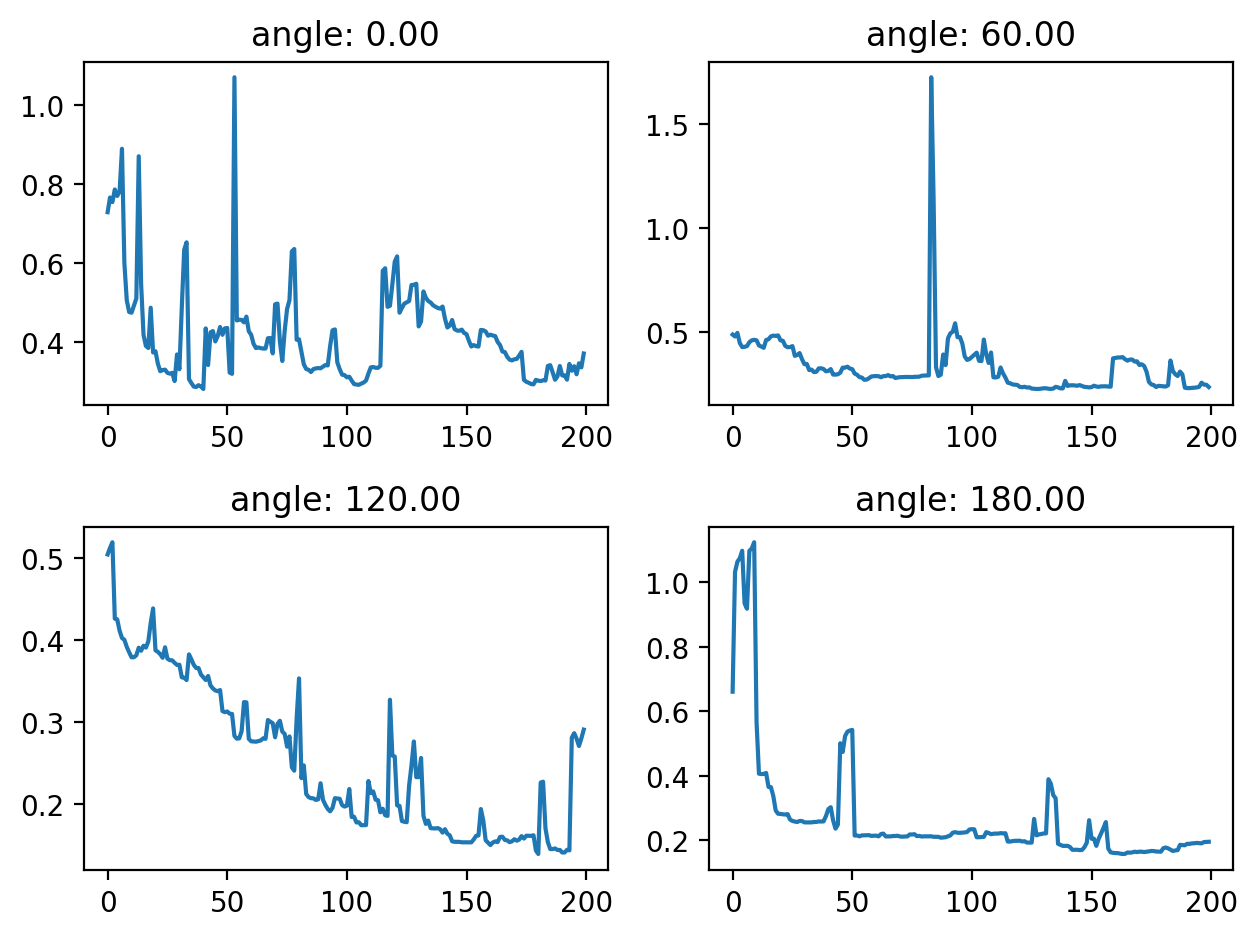

In [142]:
fdekf_outputs, bel = [], None

fig, axs = plt.subplots(2, 2)
axs = axs.ravel()

for i, ax in enumerate(axs):
    slice_ix = slice(i * n_train, n_train * (i + 1))
    rotation = rotations_train[slice_ix.start]
    deg = np.rad2deg(rotation)
    X, y = X_test[i*n_test:(i+1)*n_test], y_test[i*n_test:(i+1)*n_test]
    bel, output = apply_model(X, y, log_init_cov, log_dynamics_weights, log_dynamics_cov, log_alpha, method='fdekf', bel=bel)
    fdekf_outputs.append(output)
    ax.plot(output['test_nll'], label='test-set nll')
    ax.set_title(f"angle: {deg:0.2f}")
plt.tight_layout()

# 3. VDEKF

## 3.1 Hyperparam Tuning

In [93]:
vdekf_opt_fn = partial(opt_fn, X=X_train, y=y_train, method='vdekf')
vdekf_optimizer = BayesianOptimization(
    f=vdekf_opt_fn,
    pbounds={
        'log_init_cov': (-8, -0.1),
        'log_dynamics_weights': (-8, -0.1),
        'log_dynamics_cov': (-8, -0.1),
        'log_alpha': (-8, -0.1),
    }
)

In [94]:
vdekf_optimizer.maximize(
    init_points=50,
    n_iter=50,
)

|   iter    |  target   | log_alpha | log_dy... | log_dy... | log_in... |
-------------------------------------------------------------------------
| 1         | -4.247    | -1.07     | -2.767    | -5.682    | -1.257    |
| 2         | -1e+06    | -0.2135   | -6.596    | -1.733    | -0.2301   |
| 3         | -4.283    | -3.756    | -0.6198   | -4.548    | -0.4418   |
| 4         | -0.7026   | -4.195    | -6.557    | -2.454    | -6.046    |
| 5         | -1e+06    | -0.5132   | -6.661    | -4.262    | -1.54     |
| 6         | -1e+06    | -0.7787   | -1.298    | -2.785    | -1.396    |
| 7         | -2.933    | -1.266    | -4.919    | -2.999    | -0.7517   |
| 8         | -0.4142   | -2.987    | -2.684    | -3.557    | -4.741    |
| 9         | -4.281    | -2.011    | -0.4924   | -3.792    | -1.31     |
| 10        | -0.6504   | -7.625    | -5.581    | -1.99     | -0.3631   |
| 11        | -3.415    | -5.689    | -1.003    | -5.508    | -6.856    |
| 12        | -0.6934   | -2.009    | 

In [95]:
# 'log_alpha': -4.095100324385516, 'log_dynamics_cov': -5.2240387876395165, 'log_dynamics_weights': -7.921065775689074, 'log_init_cov': -0.4402872420317081
print(vdekf_optimizer.max)

{'target': -0.3695003092288971, 'params': {'log_alpha': -4.095100324385516, 'log_dynamics_cov': -5.2240387876395165, 'log_dynamics_weights': -7.921065775689074, 'log_init_cov': -0.4402872420317081}}


## 3.2 Test-Set Eval

In [111]:
# Tuned hyperparams
log_alpha=-4.095100324385516
log_dynamics_cov=-5.2240387876395165
log_dynamics_weights=-7.921065775689074
log_init_cov=-0.4402872420317081

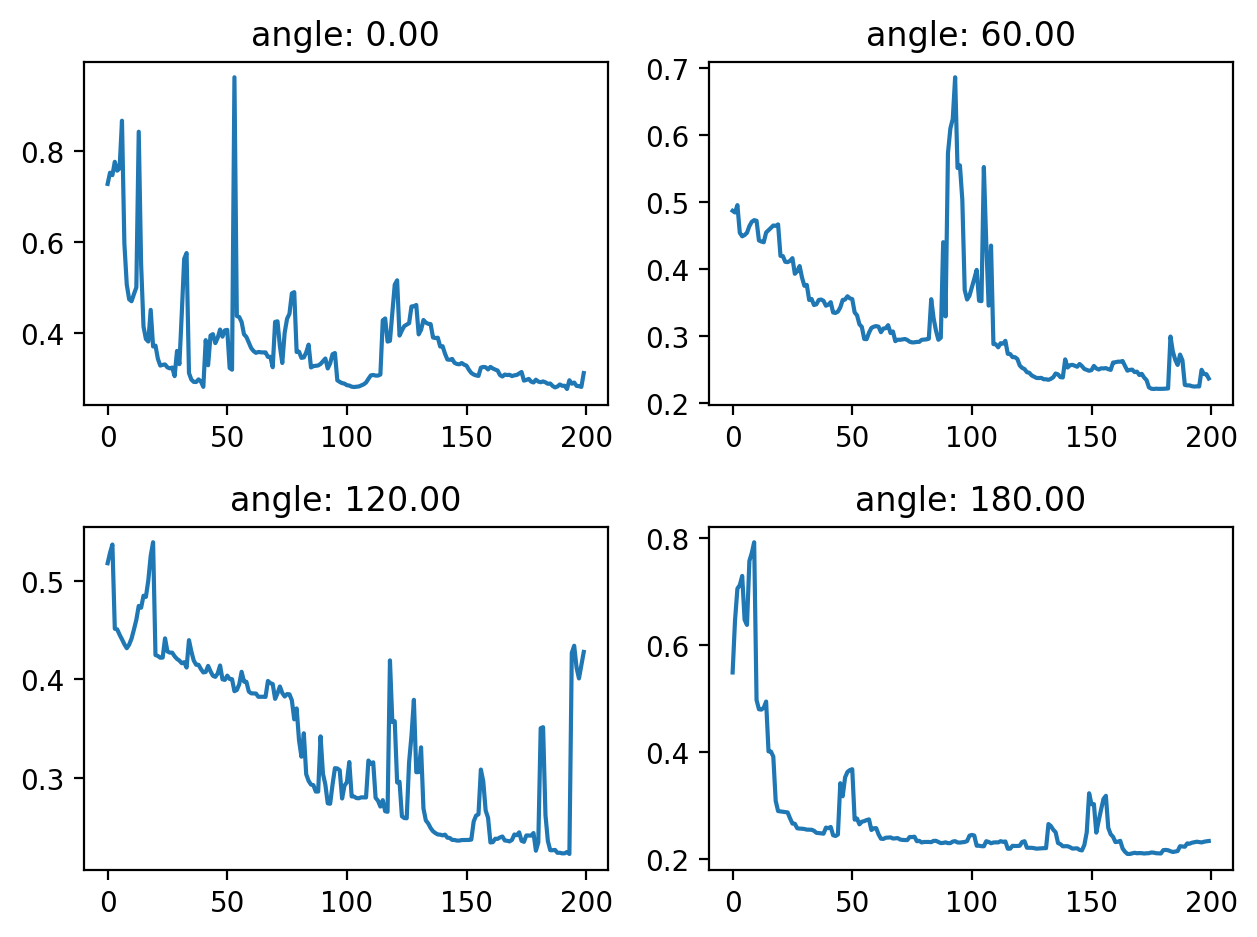

In [138]:
vdekf_outputs, bel = [], None

fig, axs = plt.subplots(2, 2)
axs = axs.ravel()

for i, ax in enumerate(axs):
    slice_ix = slice(i * n_train, n_train * (i + 1))
    rotation = rotations_train[slice_ix.start]
    deg = np.rad2deg(rotation)
    X, y = X_test[i*n_test:(i+1)*n_test], y_test[i*n_test:(i+1)*n_test]
    bel, output = apply_model(X, y, log_init_cov, log_dynamics_weights, log_dynamics_cov, log_alpha, method='vdekf', bel=bel)
    vdekf_outputs.append(output)
    ax.plot(output['test_nll'], label='test-set nll')
    ax.set_title(f"angle: {deg:0.2f}")
plt.tight_layout()

# 4. OS-LoFi

## 4.1 Hyperparam Tuning

In [115]:
os_lofi_opt_fn = partial(opt_fn, X=X_train, y=y_train, method='orth_svd_lofi')
os_lofi_optimizer = BayesianOptimization(
    f=os_lofi_opt_fn,
    pbounds={
        'log_init_cov': (-8, -0.1),
        'log_dynamics_weights': (-8, -0.1),
        'log_dynamics_cov': (-8, -0.1),
        'log_alpha': (-8, -0.1),
    }
)

In [116]:
os_lofi_optimizer.maximize(
    init_points=50,
    n_iter=50,
)

|   iter    |  target   | log_alpha | log_dy... | log_dy... | log_in... |
-------------------------------------------------------------------------
| 1         | -0.6931   | -7.84     | -6.082    | -0.4191   | -6.91     |
| 2         | -0.539    | -7.995    | -4.473    | -5.458    | -2.666    |
| 3         | -0.7117   | -2.02     | -6.293    | -2.981    | -4.015    |
| 4         | -0.7118   | -1.016    | -7.517    | -5.439    | -5.528    |
| 5         | -0.711    | -5.273    | -1.135    | -1.009    | -2.502    |
| 6         | -4.301    | -5.177    | -0.5663   | -2.902    | -1.736    |
| 7         | -0.6921   | -0.3987   | -6.315    | -2.146    | -1.606    |
| 8         | -1.549    | -0.351    | -2.357    | -6.194    | -2.558    |
| 9         | -0.6942   | -6.855    | -7.05     | -1.616    | -2.588    |
| 10        | -0.6807   | -0.1136   | -5.576    | -7.485    | -5.148    |
| 11        | -0.7115   | -3.854    | -7.221    | -5.098    | -7.189    |
| 12        | -0.5254   | -5.61     | 

In [117]:
print(os_lofi_optimizer.max)

{'target': -0.3708156645298004, 'params': {'log_alpha': -5.048544974319061, 'log_dynamics_cov': -3.751005014070363, 'log_dynamics_weights': -7.982158106456857, 'log_init_cov': -0.5919096039473564}}


## 4.2 Test-Set Eval

In [124]:
# Tuned hyperparams
log_alpha=-5.048544974319061
log_dynamics_cov=-3.751005014070363
log_dynamics_weights=-7.982158106456857
log_init_cov=-0.5919096039473564

In [146]:
os_lofi_outputs

[{'osa_nll': Array([8.67879987e-01, 1.22438598e+00, 7.47569680e-01, 5.87560356e-01,
         4.63650912e-01, 2.70368427e-01, 3.74123454e-01, 1.60763252e+00,
         8.18308353e-01, 2.89482653e-01, 2.34878287e-01, 1.32876679e-01,
         1.02092095e-01, 5.52211881e-01, 1.08122182e+00, 1.06952572e+00,
         2.08557606e-01, 1.07395343e-01, 1.16042089e+00, 4.20813173e-01,
         1.17290698e-01, 1.45334587e-01, 8.22139308e-02, 7.07719699e-02,
         1.05917836e-02, 8.96023035e-01, 1.48567200e-01, 1.91951208e-02,
         2.54580975e-01, 7.96315074e-01, 3.58430594e-01, 1.15317464e+00,
         1.99947253e-01, 4.17502970e-02, 9.90954638e-01, 3.11209410e-01,
         1.30012587e-01, 1.06756285e-01, 5.81014305e-02, 1.37256812e-02,
         9.99479294e-02, 1.90601110e+00, 8.98290575e-01, 4.59366083e-01,
         3.19479289e-03, 1.53145820e-01, 2.18852628e-02, 6.80740848e-02,
         9.15444717e-02, 3.02830674e-02, 6.28227717e-04, 7.08971560e-01,
         1.95916388e-02, 4.24388170e+00,

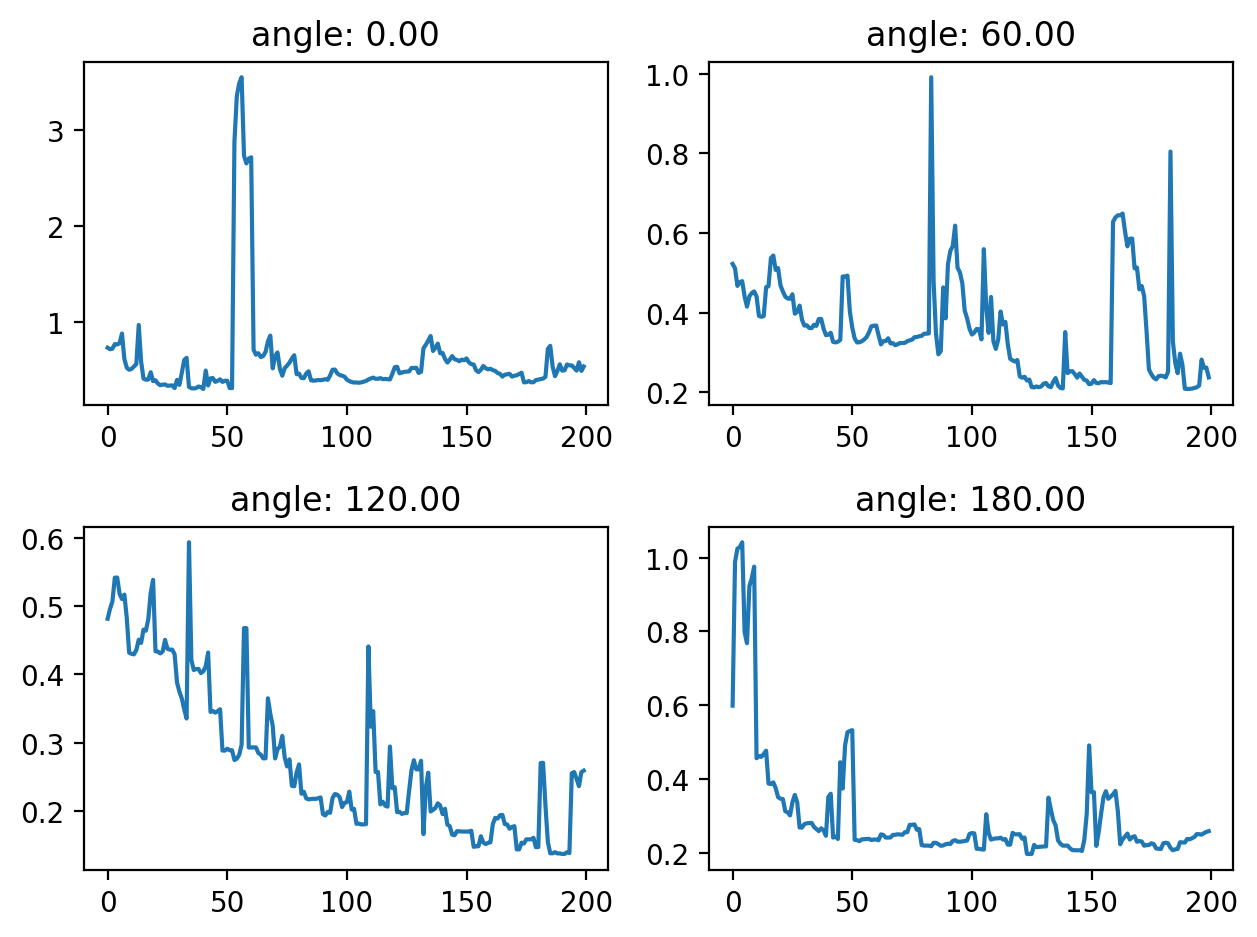

In [139]:
os_lofi_outputs, bel = [], None

fig, axs = plt.subplots(2, 2)
axs = axs.ravel()

for i, ax in enumerate(axs):
    slice_ix = slice(i * n_train, n_train * (i + 1))
    rotation = rotations_train[slice_ix.start]
    deg = np.rad2deg(rotation)
    X, y = X_test[i*n_test:(i+1)*n_test], y_test[i*n_test:(i+1)*n_test]
    bel, output = apply_model(X, y, log_init_cov, log_dynamics_weights, log_dynamics_cov, log_alpha, method='orth_svd_lofi', bel=bel)
    os_lofi_outputs.append(output)
    ax.plot(output['test_nll'], label='test-set nll')
    ax.set_title(f"angle: {deg:0.2f}")
plt.tight_layout()

# 5. FS-LoFi

## 5.1 Hyperparam Tuning

In [118]:
fs_lofi_opt_fn = partial(opt_fn, X=X_train, y=y_train, method='full_svd_lofi')
fs_lofi_optimizer = BayesianOptimization(
    f=fs_lofi_opt_fn,
    pbounds={
        'log_init_cov': (-8, -0.1),
        'log_dynamics_weights': (-8, -0.1),
        'log_dynamics_cov': (-8, -0.1),
        'log_alpha': (-8, -0.1),
    }
)

In [119]:
fs_lofi_optimizer.maximize(
    init_points=50,
    n_iter=50,
)

|   iter    |  target   | log_alpha | log_dy... | log_dy... | log_in... |
-------------------------------------------------------------------------
| 1         | -0.4287   | -0.652    | -3.448    | -7.262    | -3.351    |
| 2         | -3.609    | -4.034    | -1.764    | -6.453    | -7.556    |
| 3         | -0.2997   | -5.548    | -3.306    | -7.818    | -0.8371   |
| 4         | -4.165    | -3.312    | -1.313    | -2.994    | -6.473    |
| 5         | -0.6993   | -6.661    | -6.237    | -2.268    | -3.614    |
| 6         | -0.6934   | -2.15     | -6.036    | -1.076    | -0.7485   |
| 7         | -0.5813   | -3.982    | -4.702    | -3.681    | -2.056    |
| 8         | -4.479    | -1.584    | -0.2429   | -1.841    | -1.6      |
| 9         | -0.6932   | -5.333    | -3.715    | -0.7613   | -2.657    |
| 10        | -4.256    | -6.07     | -0.8066   | -5.785    | -4.682    |
| 11        | -0.3553   | -2.546    | -2.413    | -2.655    | -5.609    |
| 12        | -0.7085   | -0.951    | 

In [126]:
# 'log_alpha': -2.2218792413148787, 'log_dynamics_cov': -8.0, 'log_dynamics_weights': -8.0, 'log_init_cov': -0.1
print(fs_lofi_optimizer.max)

{'target': -0.2825796902179718, 'params': {'log_alpha': -2.2218792413148787, 'log_dynamics_cov': -8.0, 'log_dynamics_weights': -8.0, 'log_init_cov': -0.1}}


## 5.2 Test-Set Eval

In [127]:
# Tuned hyperparams
log_alpha=-2.2218792413148787
log_dynamics_cov=-8.0
log_dynamics_weights=-8.0
log_init_cov=-0.1

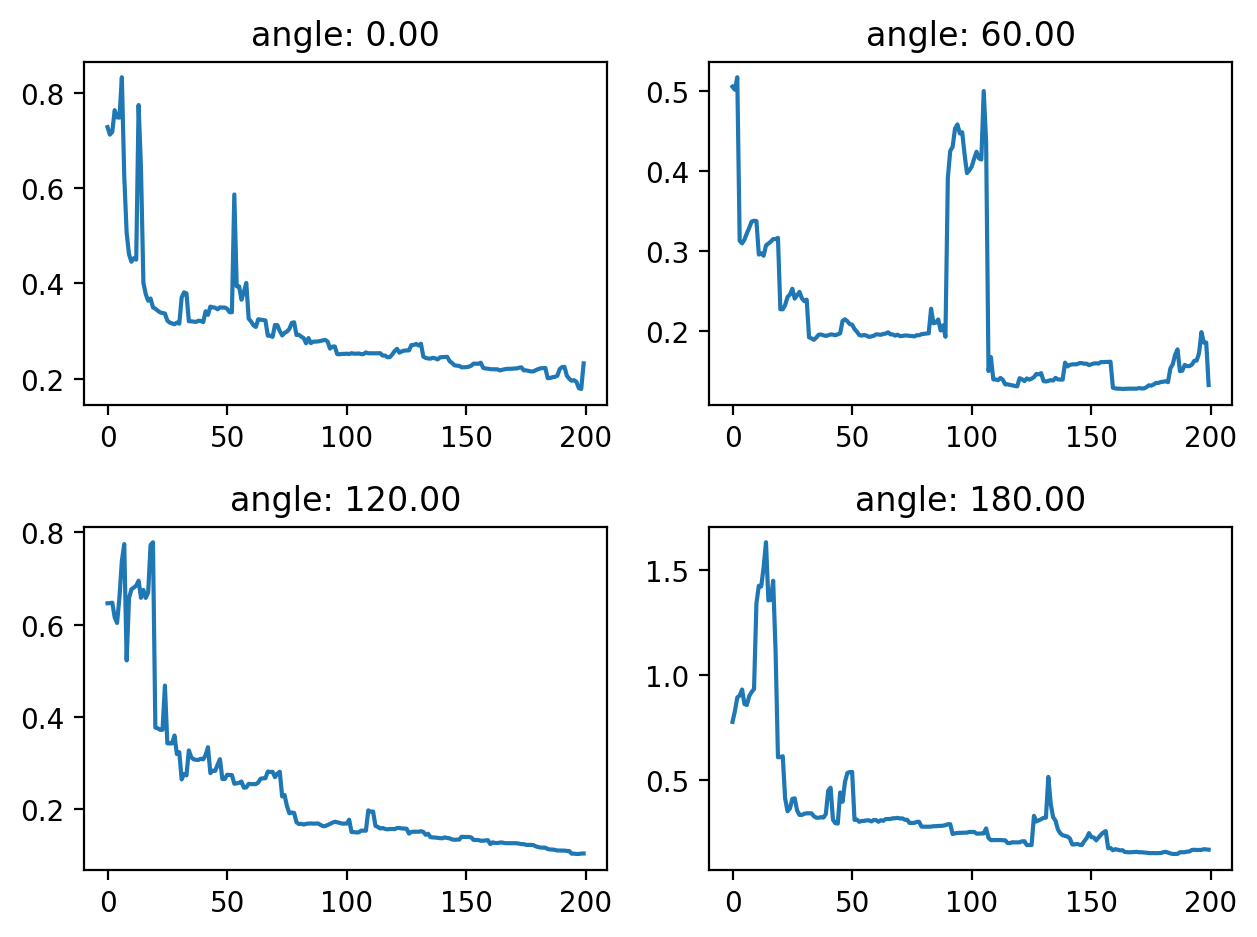

In [140]:
fs_lofi_outputs, bel = [], None

fig, axs = plt.subplots(2, 2)
axs = axs.ravel()

for i, ax in enumerate(axs):
    slice_ix = slice(i * n_train, n_train * (i + 1))
    rotation = rotations_train[slice_ix.start]
    deg = np.rad2deg(rotation)
    X, y = X_test[i*n_test:(i+1)*n_test], y_test[i*n_test:(i+1)*n_test]
    bel, output = apply_model(X, y, log_init_cov, log_dynamics_weights, log_dynamics_cov, log_alpha, method='full_svd_lofi', bel=bel)
    fs_lofi_outputs.append(output)
    ax.plot(output['test_nll'], label='test-set nll')
    ax.set_title(f"angle: {deg:0.2f}")
plt.tight_layout()

# 6. G-LoFi

## 6.1 Hyperparam Tuning

In [121]:
g_lofi_opt_fn = partial(opt_fn, X=X_train, y=y_train, method='generalized_lofi')
g_lofi_optimizer = BayesianOptimization(
    f=g_lofi_opt_fn,
    pbounds={
        'log_init_cov': (-8, -0.1),
        'log_dynamics_weights': (-8, -0.1),
        'log_dynamics_cov': (-8, -0.1),
        'log_alpha': (-8, -0.1),
    }
)

In [122]:
g_lofi_optimizer.maximize(
    init_points=50,
    n_iter=50,
)

|   iter    |  target   | log_alpha | log_dy... | log_dy... | log_in... |
-------------------------------------------------------------------------
| 1         | -0.5444   | -7.509    | -4.423    | -7.344    | -2.354    |
| 2         | -0.6983   | -5.527    | -6.835    | -7.325    | -3.501    |
| 3         | -0.6943   | -3.51     | -3.918    | -1.617    | -4.652    |
| 4         | -0.6786   | -6.714    | -5.222    | -1.794    | -0.2446   |
| 5         | -1.816    | -1.022    | -1.74     | -4.716    | -7.636    |
| 6         | -0.694    | -4.283    | -1.481    | -0.4228   | -7.073    |
| 7         | -0.6945   | -1.047    | -6.637    | -1.674    | -4.967    |
| 8         | -0.6459   | -1.308    | -5.349    | -3.537    | -2.319    |
| 9         | -0.7096   | -2.64     | -6.867    | -7.635    | -5.131    |
| 10        | -0.694    | -1.341    | -3.748    | -1.535    | -4.164    |
| 11        | -4.253    | -1.628    | -1.277    | -7.941    | -2.066    |
| 12        | -0.4058   | -2.311    | 

In [130]:
# 'log_alpha': -6.325597574833292, 'log_dynamics_cov': -5.552353754498174, 'log_dynamics_weights': -4.142608023499558, 'log_init_cov': -0.1
print(g_lofi_optimizer.max)

{'target': -0.28717687726020813, 'params': {'log_alpha': -6.325597574833292, 'log_dynamics_cov': -5.552353754498174, 'log_dynamics_weights': -4.142608023499558, 'log_init_cov': -0.1}}


## 6.2 Test-Set Eval

In [131]:
# Tuned hyperparams
log_alpha=-6.325597574833292
log_dynamics_cov=-5.552353754498174
log_dynamics_weights=-4.142608023499558
log_init_cov=-0.1

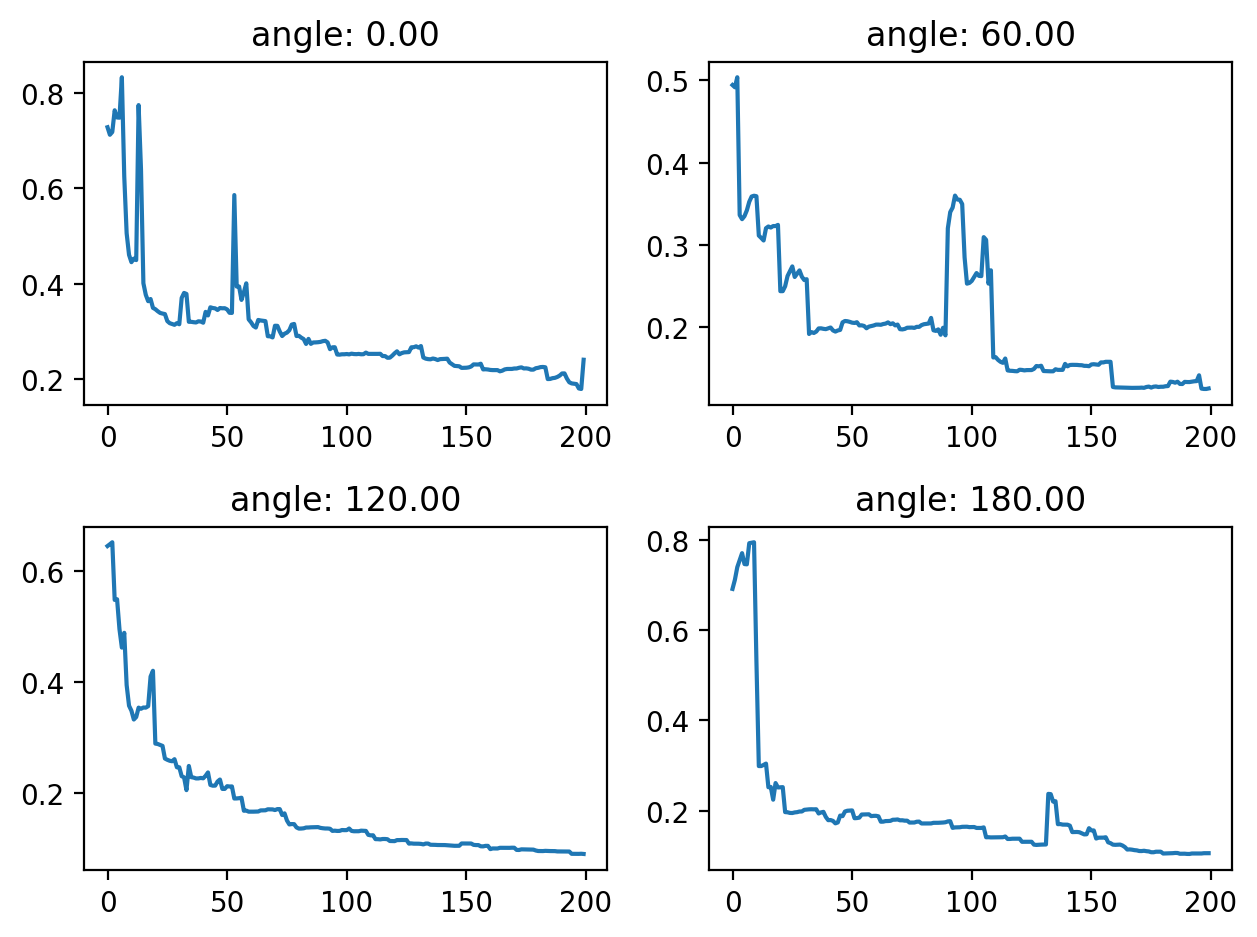

In [141]:
g_lofi_outputs, bel = [], None

fig, axs = plt.subplots(2, 2)
axs = axs.ravel()

for i, ax in enumerate(axs):
    slice_ix = slice(i * n_train, n_train * (i + 1))
    rotation = rotations_train[slice_ix.start]
    deg = np.rad2deg(rotation)
    X, y = X_test[i*n_test:(i+1)*n_test], y_test[i*n_test:(i+1)*n_test]
    bel, output = apply_model(X, y, log_init_cov, log_dynamics_weights, log_dynamics_cov, log_alpha, method='generalized_lofi', bel=bel)
    g_lofi_outputs.append(output)
    ax.plot(output['test_nll'], label='test-set nll')
    ax.set_title(f"angle: {deg:0.2f}")
plt.tight_layout()

# 7. Model Comparison

In [143]:
result = {
    'fcekf': fcekf_outputs,
    'fdekf': fdekf_outputs,
    'vdekf': vdekf_outputs,
    'os-lofi': os_lofi_outputs,
    'fs-lofi': fs_lofi_outputs,
    'g-lofi': g_lofi_outputs,
}

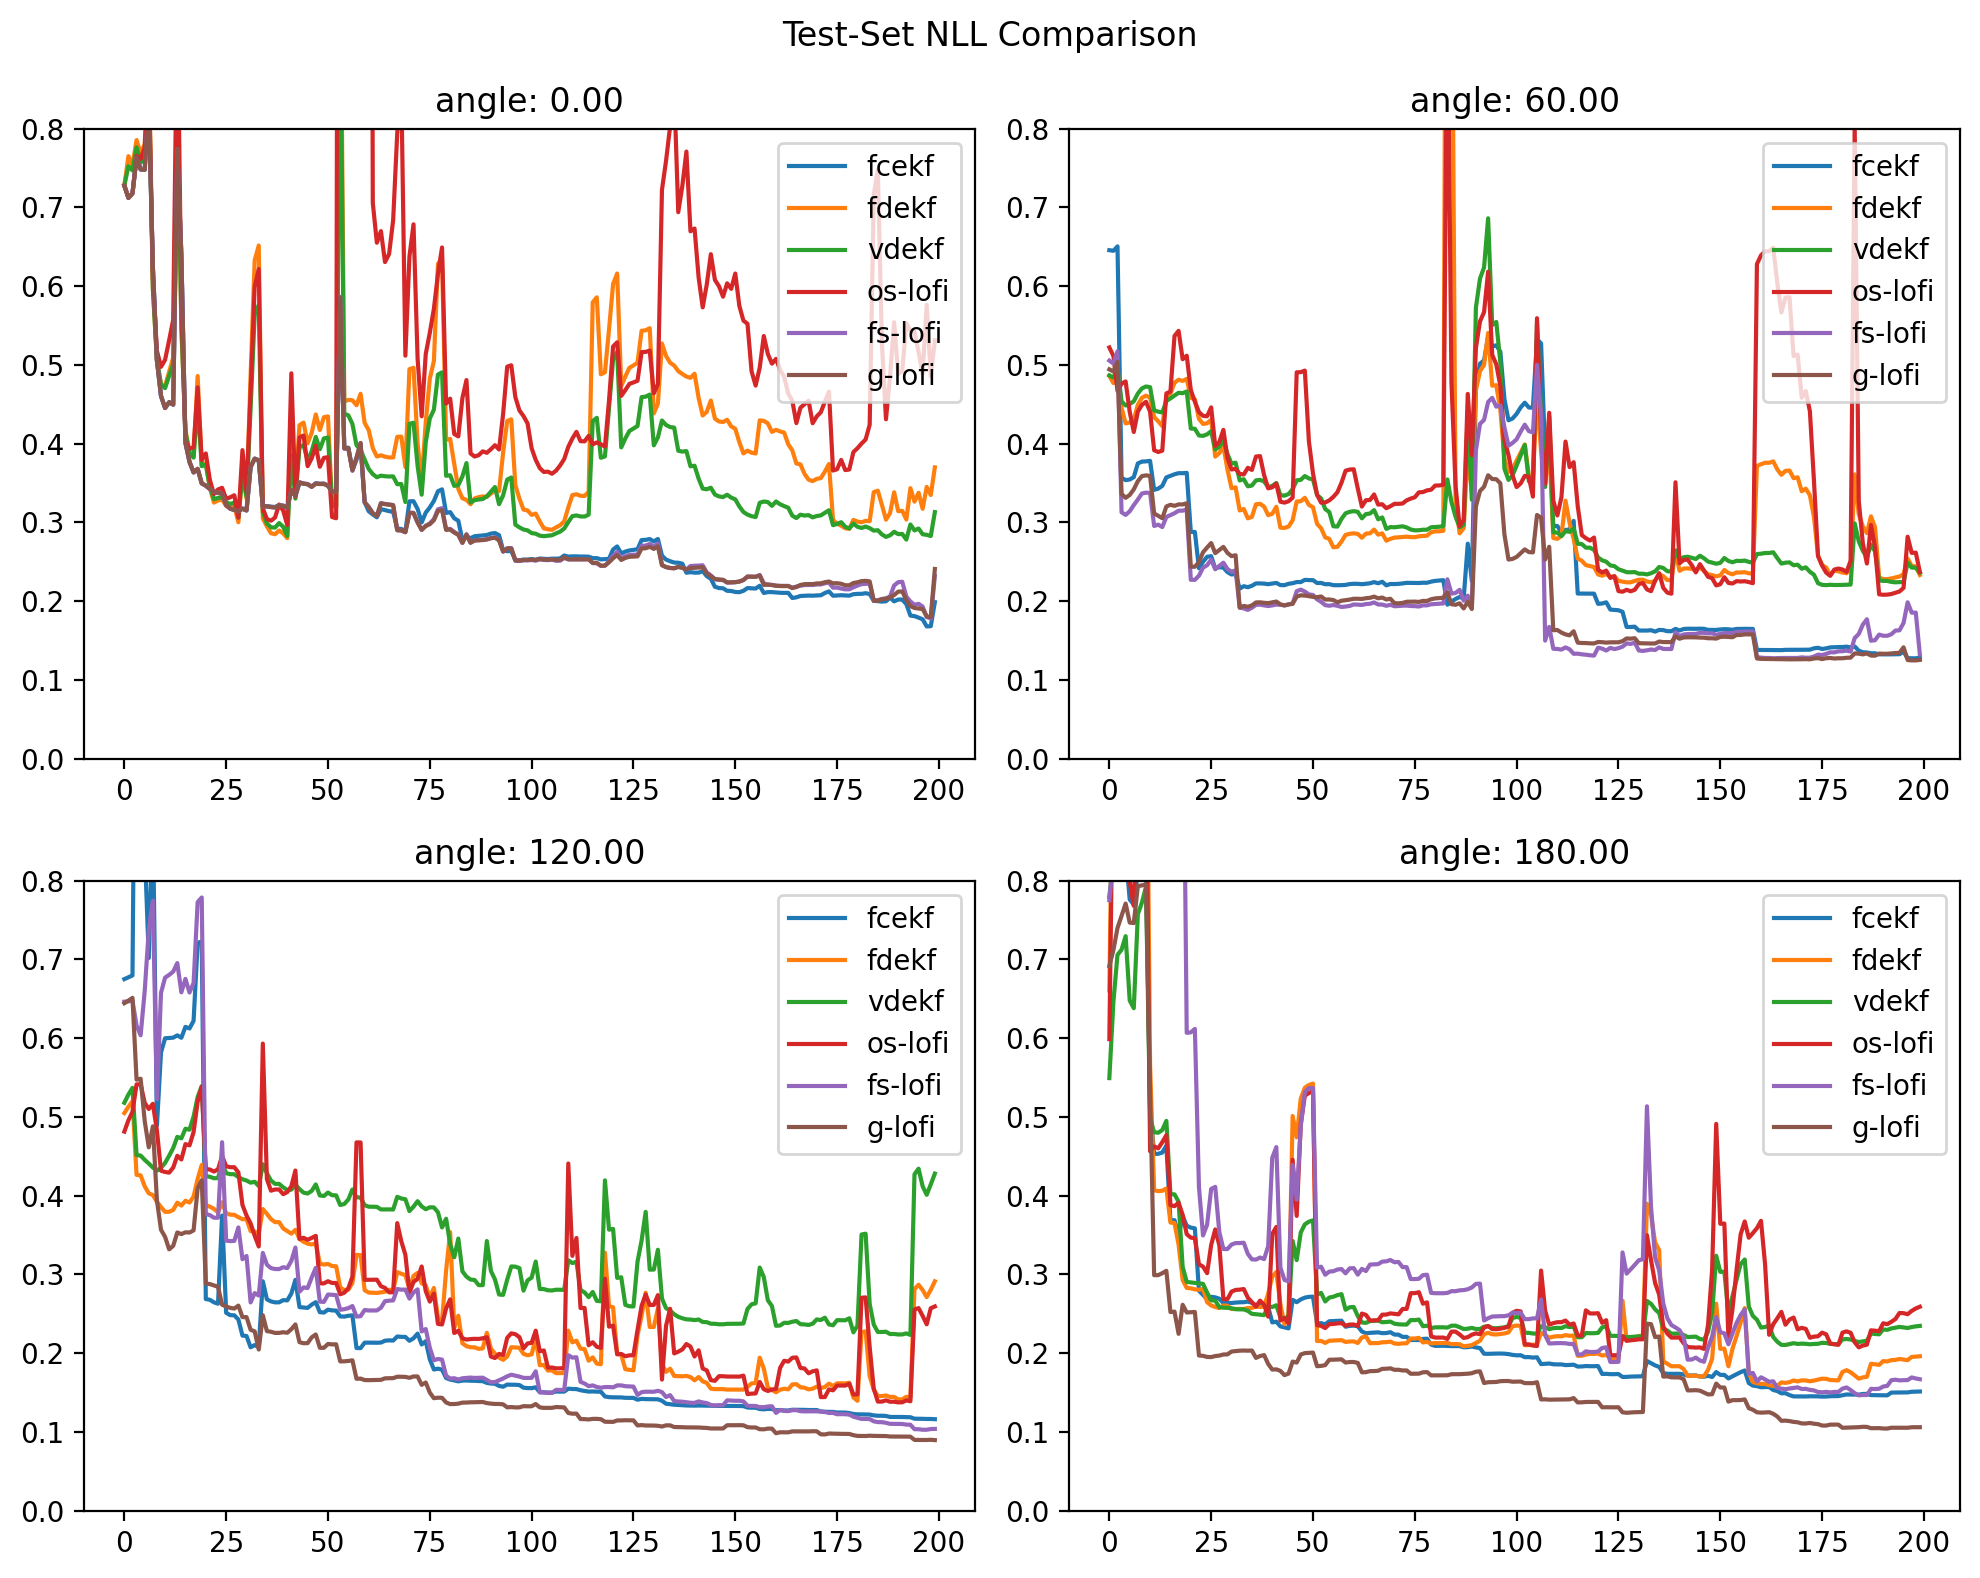

In [154]:
# Test-Set NLL Comparison
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
axs = axs.ravel()

for i, ax in enumerate(axs):
    slice_ix = slice(i * n_train, n_train * (i + 1))
    rotation = rotations_train[slice_ix.start]
    deg = np.rad2deg(rotation)
    for key, val in result.items():
        ax.plot(val[i]['test_nll'], label=key)    
    ax.set_title(f"angle: {deg:0.2f}")
    ax.set_ylim(0.0, 0.8)
    ax.legend()
fig.suptitle('Test-Set NLL Comparison')
plt.tight_layout();

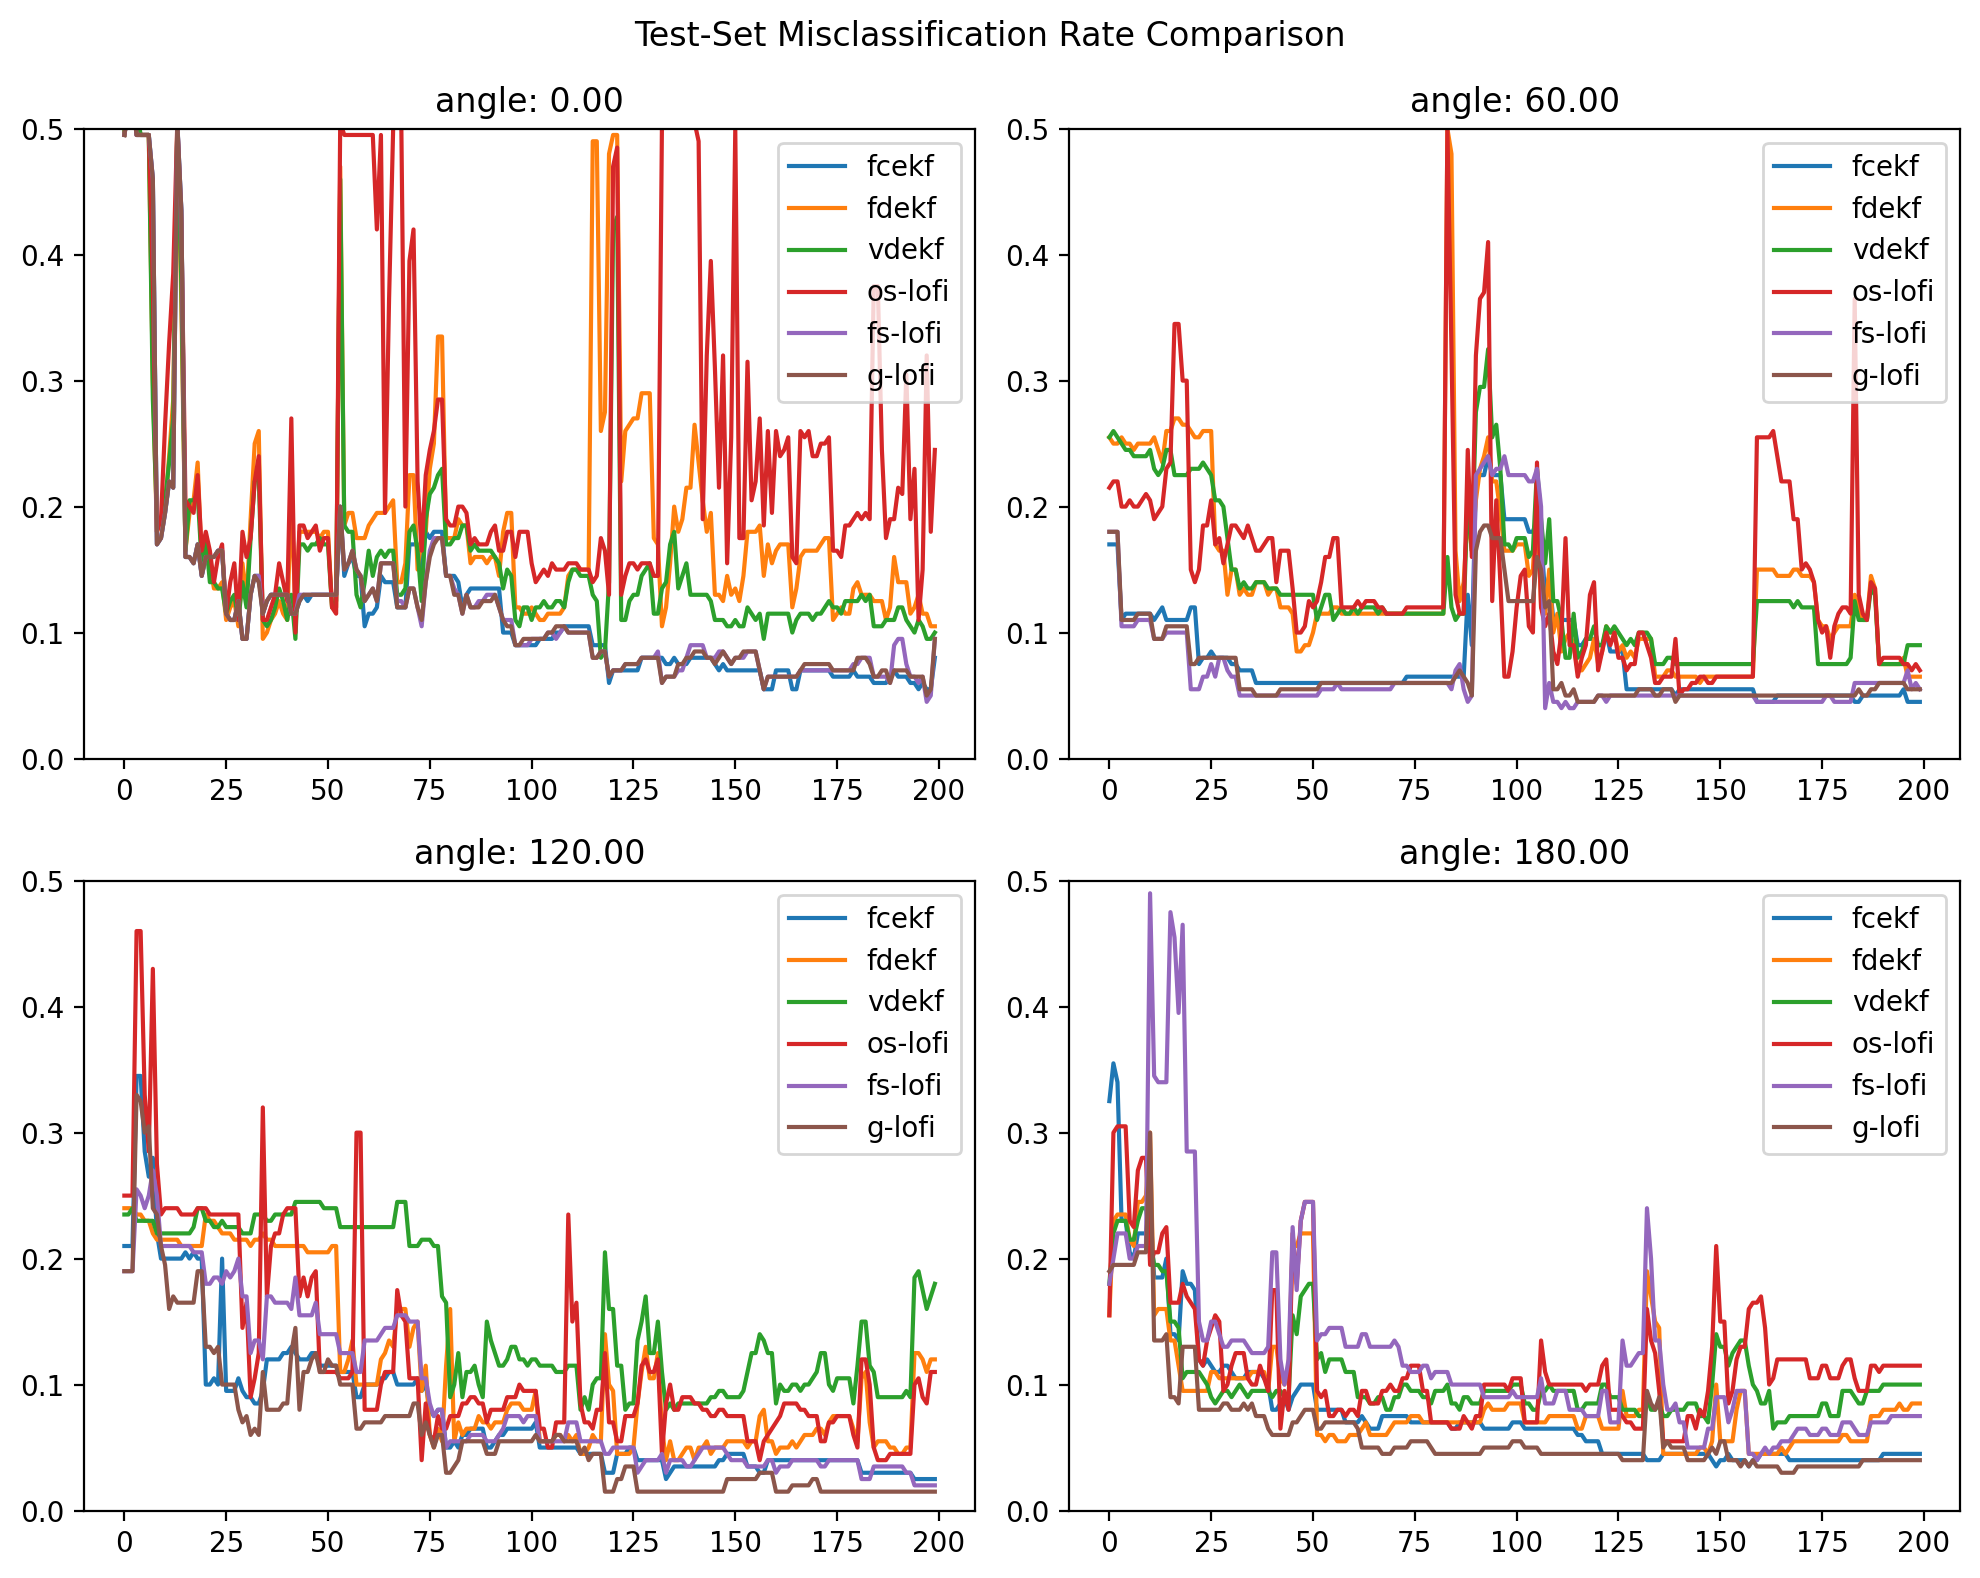

In [156]:
# Test-Set Misclassification Rate Comparison
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
axs = axs.ravel()

for i, ax in enumerate(axs):
    slice_ix = slice(i * n_train, n_train * (i + 1))
    rotation = rotations_train[slice_ix.start]
    deg = np.rad2deg(rotation)
    for key, val in result.items():
        ax.plot(val[i]['test_miscl'], label=key)    
    ax.set_title(f"angle: {deg:0.2f}")
    ax.set_ylim(0.0, 0.5)
    ax.legend()
fig.suptitle('Test-Set Misclassification Rate Comparison')
plt.tight_layout();